In [1]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
unmasker("Hello I'm a [MASK] model.")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default.

[{'score': 0.10182059556245804,
  'token': 13192,
  'token_str': 'model',
  'sequence': "Hello I'm a model model."},
 {'score': 0.05212637409567833,
  'token': 11356,
  'token_str': 'world',
  'sequence': "Hello I'm a world model."},
 {'score': 0.048930197954177856,
  'token': 11165,
  'token_str': 'data',
  'sequence': "Hello I'm a data model."},
 {'score': 0.02036011777818203,
  'token': 23578,
  'token_str': 'flight',
  'sequence': "Hello I'm a flight model."},
 {'score': 0.02007964998483658,
  'token': 14155,
  'token_str': 'business',
  'sequence': "Hello I'm a business model."}]

In [2]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [3]:
text = "এখনো ইউজ করি নাই তবে দেখে প্রিমিয়াম মনে হচ্ছে  আশা করি ভালো হবে  সুন্দর"
tokens = tokenizer.tokenize(text)
print(tokens)

['এ', '##খ', '##নো', 'ই', '##উ', '##জ', 'ক', '##রি', 'না', '##ই', 'তবে', 'দ', '##ে', '##খে', 'প', '##্রি', '##মি', '##য়া', '##ম', 'মনে', 'হচ্ছে', 'আ', '##শা', 'ক', '##রি', 'ভ', '##াল', '##ো', 'হবে', 'স', '##ুন', '##্দ', '##র']


# Multilingual BERT

# Important Libraries

In [4]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, EarlyStoppingCallback
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt  # Importing matplotlib for plotting

# Load Dataset

In [5]:
train_data = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\train_data_df.xlsx')
val_data = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\val_data_df.xlsx')
test_data = pd.read_excel(r'E:\Bangla-Sentiment-Analysis\Bangla_Dataset\test_data_df.xlsx')

In [6]:
train_data.head(5)

,clean_sentence,Sentiment
0,অর্ডার প্লেসমেন্ট সাউন্ড কোয়ালিটি মাত্র দিনগু...,Positive
1,টাকা রেঞ্জে একটা ভালো ডিল বলা যায় যদি অফারে নি...,Positive
2,শালীন সাউন্ড কোয়ালিটি দুর্দান্ত বাস মানের মাই...,Positive
3,পারফরম্যান্স ভালো পাচ্ছি কিন্তু এর কৃত্রিম সংক...,Neutral
4,খুব ভালো,Positive


In [7]:
# Sentiment Mapping
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}

# Apply the mapping 
train_data['Sentiment'] = train_data['Sentiment'].map(sentiment_mapping)
val_data['Sentiment'] = val_data['Sentiment'].map(sentiment_mapping)
test_data['Sentiment'] = test_data['Sentiment'].map(sentiment_mapping)


In [8]:
# BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=184,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Dataloader 

In [9]:
# Prepare DataLoader
train_dataset = SentimentDataset(train_data['clean_sentence'].tolist(), train_data['Sentiment'].tolist())
val_dataset = SentimentDataset(val_data['clean_sentence'].tolist(), val_data['Sentiment'].tolist())
test_dataset = SentimentDataset(test_data['clean_sentence'].tolist(), test_data['Sentiment'].tolist())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize Model

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Optimizer
optimizer = AdamW(model.parameters(), lr=0.00001)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Train Model

In [11]:
# Initialize lists to track losses
train_losses = []
val_losses = []

# Training function
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, patience=3):
    best_val_loss = float('inf')  # Initialize the best validation loss
    patience_counter = 0  # Counter to track how long validation loss has not improved

    model.train()
    for epoch in range(num_epochs):
        total_train_loss = 0
        model.train()  # Set the model to training mode

        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Append training loss
        print(f'Epoch {epoch + 1}')
        print(f'Train Loss: {avg_train_loss}')

        # Validation
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to('cuda')
                attention_mask = batch['attention_mask'].to('cuda')
                labels = batch['labels'].to('cuda')

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

                preds = torch.argmax(outputs.logits, dim=-1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)  # Append validation loss
        f1 = f1_score(val_labels, val_preds, average='weighted')
        precision = precision_score(val_labels, val_preds, average='weighted')
        recall = recall_score(val_labels, val_preds, average='weighted')
        accuracy = np.mean(np.array(val_labels) == np.array(val_preds))

        print(f'Validation Loss: {avg_val_loss}')
        print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1}, Precision: {precision}, Recall: {recall}')

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # Reset patience counter if validation loss improves
            print("Validation loss improved, saving the model...")
            torch.save(model.state_dict(), 'best_model.pt')  # Save the model if validation loss improves
        else:
            patience_counter += 1  # Increment the patience counter
            print(f'No improvement in validation loss for {patience_counter} epoch(s).')

        if patience_counter >= patience:
            print(f'Early stopping triggered after {patience_counter} epochs without improvement.')
            break  # Exit the training loop if patience has been exceeded

# Train the model 
train_model(model, train_loader, val_loader, optimizer, num_epochs=10, patience=2)

  0%|          | 0/2575 [00:00<?, ?it/s]C:\Users\Rizvi\AppData\Roaming\Python\Python312\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 2575/2575 [03:06<00:00, 13.79it/s]


Epoch 1
Train Loss: 0.8232426732141995
Validation Loss: 0.7495650796765122
Accuracy: 0.6849, F1 Score: 0.6591075307547047, Precision: 0.6588774878301821, Recall: 0.6848576954959934
Validation loss improved, saving the model...


100%|██████████| 2575/2575 [03:04<00:00, 13.94it/s]


Epoch 2
Train Loss: 0.7290497970465317
Validation Loss: 0.7281076107894519
Accuracy: 0.6966, F1 Score: 0.6694942474122553, Precision: 0.6694370796627165, Recall: 0.6966012710693562
Validation loss improved, saving the model...


100%|██████████| 2575/2575 [03:07<00:00, 13.73it/s]


Epoch 3
Train Loss: 0.6772064114716446
Validation Loss: 0.7272467673318821
Accuracy: 0.6908, F1 Score: 0.685865097602464, Precision: 0.682075324070447, Recall: 0.6907985631389887
Validation loss improved, saving the model...


100%|██████████| 2575/2575 [03:04<00:00, 13.97it/s]


Epoch 4
Train Loss: 0.6313722408251855
Validation Loss: 0.7502784853317461
Accuracy: 0.6941, F1 Score: 0.6861459129414907, Precision: 0.6816163864046653, Recall: 0.6941143962420558
No improvement in validation loss for 1 epoch(s).


100%|██████████| 2575/2575 [03:01<00:00, 14.18it/s]


Epoch 5
Train Loss: 0.5677087878168208
Validation Loss: 0.7930165195251038
Accuracy: 0.6847, F1 Score: 0.6795251831765119, Precision: 0.6795449013506616, Recall: 0.6847195357833655
No improvement in validation loss for 2 epoch(s).
Early stopping triggered after 2 epochs without improvement.


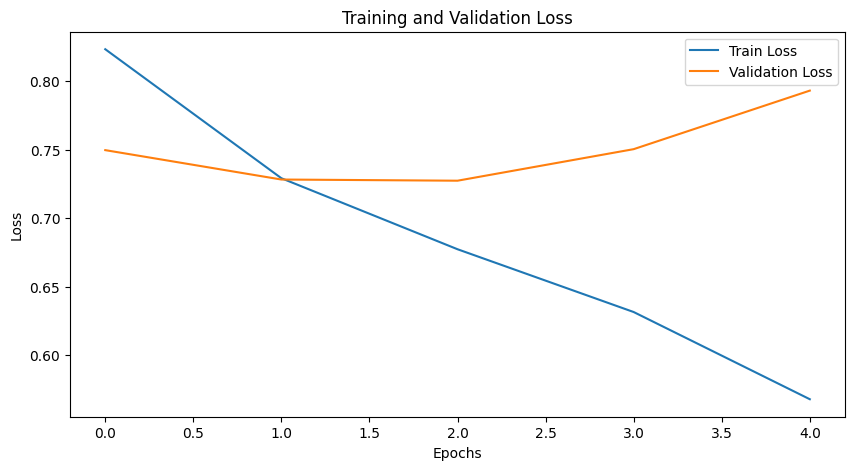

In [12]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Test Model

In [13]:
# Load the best model state (the one with the lowest validation loss) before evaluating on the test set
model.load_state_dict(torch.load('best_model.pt'))
model.eval()  

# Evaluation on Test Dataset

test_labels = []
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

test_accuracy = np.mean(np.array(test_labels) == np.array(test_preds))
f_score = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')

C:\Users\Rizvi\AppData\Local\Temp\ipykernel_736\554017075.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


--------------------------------------------------Test Set---------------------------------------------------------------------------
Evaluating on Test Dataset
Test Accuracy: 0.6943, F Score: 0.6897
Test Precision: 0.6861, Test Recall: 0.6943

Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.74      0.73      2291
     Neutral       0.42      0.37      0.39      1445
    Positive       0.78      0.81      0.79      3224

    accuracy                           0.69      6960
   macro avg       0.64      0.64      0.64      6960
weighted avg       0.69      0.69      0.69      6960


Confusion Matrix:
[[1698  343  250]
 [ 416  535  494]
 [ 222  403 2599]]


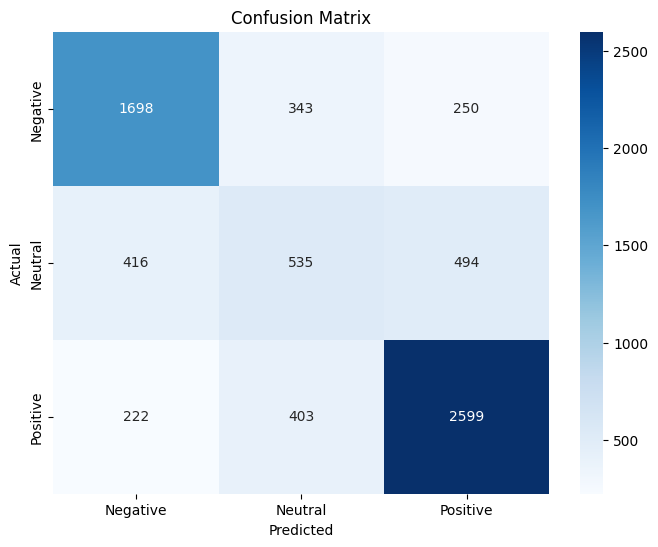

In [14]:
print("--------------------------------------------------Test Set---------------------------------------------------------------------------")
print("Evaluating on Test Dataset")
print(f"Test Accuracy: {test_accuracy:.4f}, F Score: {f_score:.4f}")
print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)

# Visualizing the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

